<a href="https://colab.research.google.com/github/YuliaLoburets/ML_learning/blob/main/HW_2_2_%D0%9F%D0%BE%D0%BB%D1%96%D0%BD%D0%BE%D0%BC%D1%96%D0%B0%D0%BB%D1%8C%D0%BD%D1%96_%D0%BE%D0%B7%D0%BD%D0%B0%D0%BA%D0%B8_Pipelines.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

В цьому домашньому завданні ми проведемо додаткові експерименти для рішення задачі бінарної класифікації і створимо ваш новий submission на змагання на Kaggle.

-----------


**Завдання 0**. Завантажте дані `train.csv`, `test.csv`, `sample_submission.csv` зі змагання на Kaggle ["Bank Customer Churn Prediction (DLU Course)"](https://www.kaggle.com/competitions/bank-customer-churn-prediction-dlu-course-c-2). Для завантаження потрібно долучитись до змагання (натиснути кнопку "Join").

**Завдання 1**. **Збираємо весь код з попереднього ДЗ в одному місці.** В лекційному ноутбуці `Логістична регресія з ScikitLearn. Повна ML задача.ipynb` ми познайомились з поняттям пайплайнів, а також я показала, як компактно виглядає рішення МЛ задачі, якщо ми зберемо весь код разом.

Оскільки ми далі будемо робити експерименти, які включають ті самі етапи попередньої обробки, але інше моделювання - буде зручно мати весь код компактно і під рукою. Тому зараз ми займемось збором коду до купи :) Після цього завдання для подальших експериментів ви можете перенести частини розвʼязку взагалі в окремий `.py` файл, аби було зручно імпортувати функції.

Зі свого рішення в попередньому домашньому завданні (`Логістична регресія з scikit learn.ipynb`) зберіть усі кроки розвʼязку задачі разом з використанням `sklearn.Pipeline` за прикладом з лекції.

Ваш код нижче має містити
1. Читання даних з файлу (поза пайплайном).
2. Розбиття на тренувальний і валідаційний набори, де валідаційний містить 20% даних (поза пайплайном).
3. Виділення категоріальних і числових колонок (поза пайплайном).
4. Підготовку категоріальних і числових колонок (частина пайплайну). В прикладі в лекції ми оформлювали обробку числових і категоріальних колонок в окремі трансформери `numeric_transformer`, `categorical_cols`. Рекоемндую зробити саме так, так потім зручніше вносити зміни :)
5. Тренування лог регресії (частина пайплайну).
6. Запуск пайплайну на тренування на трен. даних (поза пайплайном).
7. Запуск пайплайну на передбачення на трен і вал. даних і вимір метрик якості ROC-AUC + вивдення Confusion Matrix (поза пайплайном).
8. Збереження моделі в формат joblib (поза пайплайном).

Ви це все вже зробили в попереднтьому ДЗ! Тож, тут просто заадча все зібрати разом.

Нижче я додала підказки, що покроково ви маєте зробити. Якщо ви почуваєтесь впевнено, можете видалити ці підказки і реалізувати все самостійно, або ж - просто заповнити пропуски.

Завдання оцінюється в 10 балів. Головний результат - аби код в фіналі був робочий. Бо за не робочий нам гроші ніхто не заплатить :)

In [ ]:
import pandas as pd
import numpy as np
from google.colab import drive
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

In [ ]:
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


Area under ROC score on Training dataset: 0.75%
F1 score on Training dataset: 0.64%


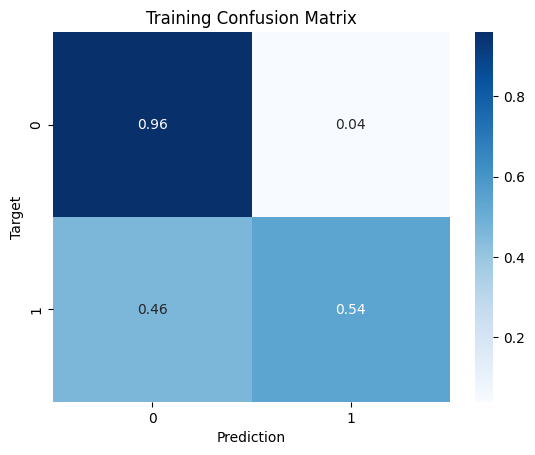

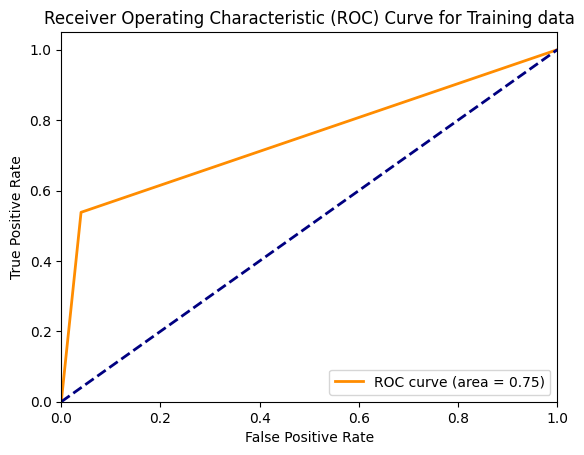

Area under ROC score on Validation dataset: 0.76%
F1 score on Validation dataset: 0.64%


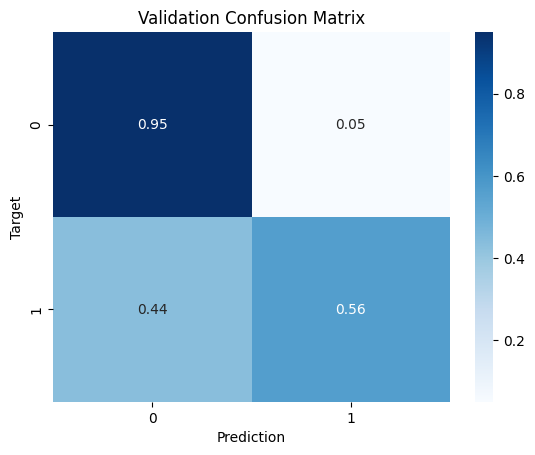

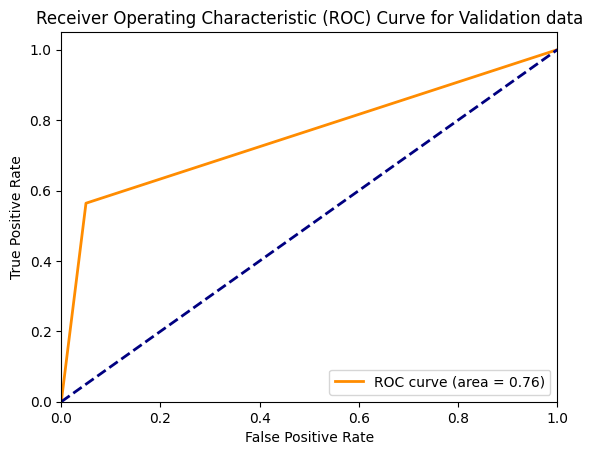

['customer_churn_rate_pipeline.joblib']

In [ ]:
raw_df = pd.read_csv('drive/MyDrive/ML/train.csv', index_col=0)

train_df, val_df = train_test_split(raw_df, test_size=0.2, random_state=42, stratify=raw_df['Exited'])

# Створюємо трен. і вал. набори
input_cols = raw_df.columns.difference(['id','CustomerId','Surname','Exited'])
target_col =  'Exited'
train_inputs, train_targets = train_df[input_cols], train_df[target_col]
val_inputs, val_targets = val_df[input_cols], val_df[target_col]

# Виявляємо числові і категоріальні колонки
numeric_cols = train_inputs.select_dtypes('number').columns.tolist()
categorical_cols = train_inputs.select_dtypes('object').columns.tolist()

# Створюємо трансформери для числових і категоріальних колонок
numeric_transformer_1 = Pipeline(steps=[
      ('scaler', MinMaxScaler())
])

categorical_transformer_1 = Pipeline(steps=[
    ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
])

# Комбінуємо трансформери для різних типів колонок в один препроцесор
preprocessor_1 = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer_1, numeric_cols),
        ('cat', categorical_transformer_1, categorical_cols)
    ])

# Стоврюємо пайплайн, який спочатку запускає препроцесинг, потім тренуєм модель
model_pipeline_1 = Pipeline(steps=[
    ('preprocessor', preprocessor_1),
    ('classifier',  LogisticRegression(solver='liblinear'))
])

# Тренуємо пайплайн
model_pipeline_1.fit(train_inputs,train_targets)

# Функція, щоб передбачати і рахувати метрики
def predict_and_plot(model_pipeline, inputs, targets, name=''):
    preds = model_pipeline.predict(inputs)
    fpr, tpr, thresholds = roc_curve(targets, preds)
    roc_auc = auc(fpr, tpr)
    f1 = f1_score(targets, preds)
    print(f"Area under ROC score on {name} dataset: {roc_auc:.2f}%")
    print(f"F1 score on {name} dataset: {f1:.2f}%")
    confusion_matrix_ = confusion_matrix(targets, preds, normalize='true')
    plt.figure()
    sns.heatmap(confusion_matrix_, annot=True, cmap='Blues')
    plt.xlabel('Prediction')
    plt.ylabel('Target')
    plt.title('{} Confusion Matrix'.format(name))
    plt.show()

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic (ROC) Curve for {name} data')
    plt.legend(loc="lower right")
    plt.show()

    return preds

# Оцінюємо модель на трен і вал даних
train_preds = predict_and_plot(model_pipeline_1,train_inputs, train_targets, name='Training')
val_preds = predict_and_plot(model_pipeline_1, val_inputs, val_targets, name='Validation')

# Зберігаємо модель для подальшого використання
joblib.dump(model_pipeline_1,'customer_churn_rate_pipeline.joblib')


**Завдання 2**. Такс, у нас з вами є вже готовий пайплайн. Давайте проведемо нові експерименти.

  Додайте в попередню обробку числових колонок генерацію polinomal features до степені 2 включно. Для цього створіть новий препроцесор і створіть новий пайплайн.

  Запустіть пайплайн на тренування і виведіть метрики для тренувального і валідаційного набору. Напишіть, як вам модель? Чи спостерігається в цій моделі overfit чи underfit? Чи ця модель добре генералізує?

In [ ]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.preprocessing import PolynomialFeatures

In [ ]:
numeric_transformer_2 = Pipeline(steps=[
      ('polinom',PolynomialFeatures(degree=2, include_bias=False)),
      ('scaler', MinMaxScaler())
])

categorical_transformer_2 = Pipeline(steps=[
    ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
])

preprocessor_2 = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer_2, numeric_cols),
        ('cat', categorical_transformer_2, categorical_cols)
    ])

model_pipeline_2 = Pipeline(steps=[
    ('preprocessor', preprocessor_2),
    ('classifier',  LogisticRegression(solver='liblinear'))
])


model_pipeline_2.fit(train_inputs,train_targets)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('polinom',
                                                                   PolynomialFeatures(include_bias=False)),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['Age', 'Balance',
                                                   'CreditScore',
                                                   'EstimatedSalary',
                                                   'HasCrCard',
                                                   'IsActiveMember',
                                                   'NumOfProducts', 'Tenure']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Gender', 'Geography'])])),
                ('classifier', LogisticRegression(solver='liblinear'))])

Area under ROC score on Polinomial_train dataset: 0.77%
F1 score on Polinomial_train dataset: 0.68%


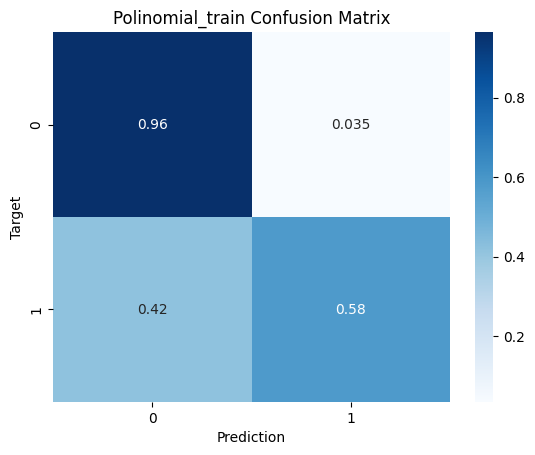

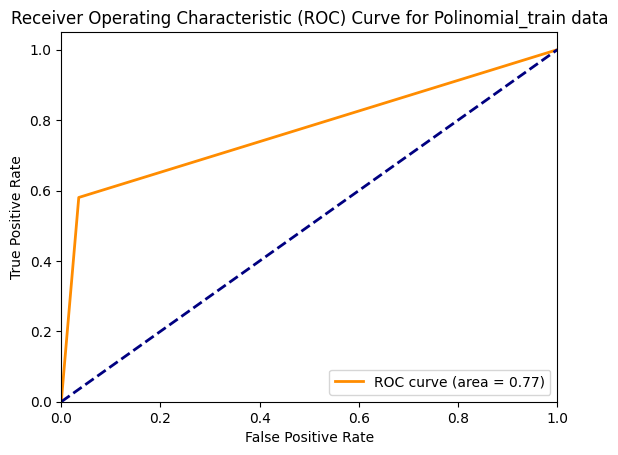

array([0., 0., 0., ..., 0., 0., 0.])

In [ ]:
predict_and_plot(model_pipeline_2, train_inputs,train_targets, name='Polinomial_train')

Area under ROC score on Polinomial_validation dataset: 0.78%
F1 score on Polinomial_validation dataset: 0.68%


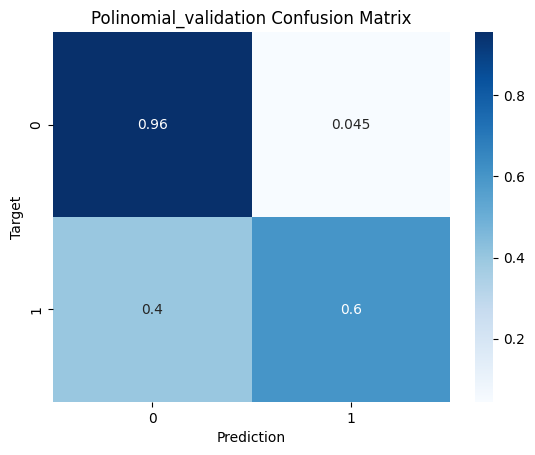

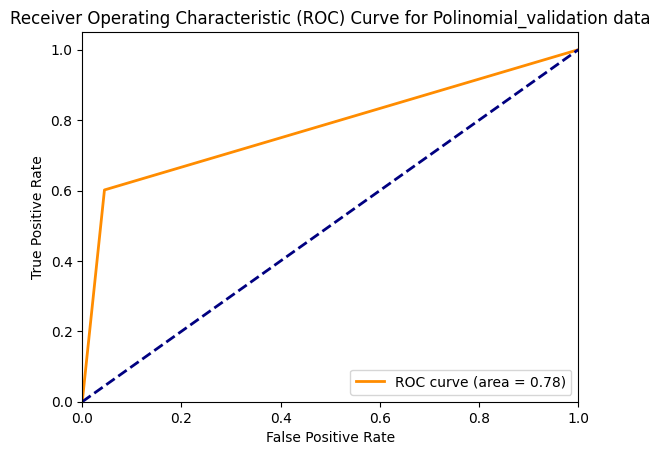

array([1., 0., 0., ..., 0., 0., 0.])

In [ ]:
predict_and_plot(model_pipeline_2, val_inputs, val_targets, name='Polinomial_validation')

У даній моделі не спостерігається overfit чи underfit . При додаванні поліноміальних ознак модель стала кращою, якщо оцінювати значення F1 та AUROC.

**Завдання 3**. Тепер давайте створимо ще новий пайплайн, тільки тепер поліноміальні ознаки згенеруємо до степені 4. Зробіть висновок про якість моделі. Якщо вам подобається резульат якоїсь з моделей в цьому ДЗ - рекомендую зробити submission в змаганні.

In [ ]:
numeric_transformer_3 = Pipeline(steps=[
      ('polinom',PolynomialFeatures(degree=4, include_bias=False)),
      ('scaler', MinMaxScaler())
])

categorical_transformer_3 = Pipeline(steps=[
    ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
])

preprocessor_3 = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer_3, numeric_cols),
        ('cat', categorical_transformer_3, categorical_cols)
    ])

model_pipeline_3 = Pipeline(steps=[
    ('preprocessor', preprocessor_3),
    ('classifier',  LogisticRegression(solver='liblinear'))
])


model_pipeline_3.fit(train_inputs,train_targets)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('polinom',
                                                                   PolynomialFeatures(degree=4,
                                                                                      include_bias=False)),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['Age', 'Balance',
                                                   'CreditScore',
                                                   'EstimatedSalary',
                                                   'HasCrCard',
                                                   'IsActiveMember',
                                                   'NumOfProducts', 'Tenure']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Gender', 'Geography'])])),
                ('classifier', LogisticRegression(solver='liblinear'))])

Area under ROC score on Polinomial_train dataset: 0.81%
F1 score on Polinomial_train dataset: 0.73%


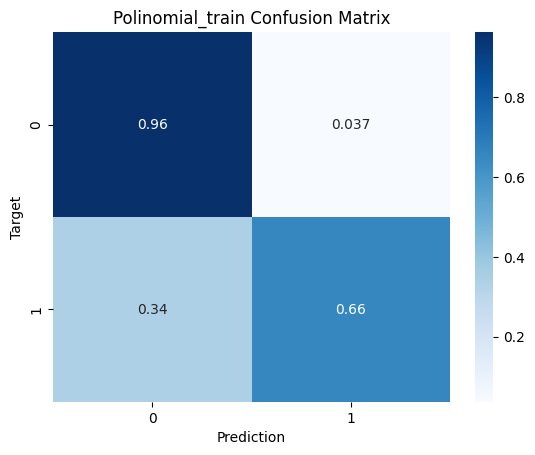

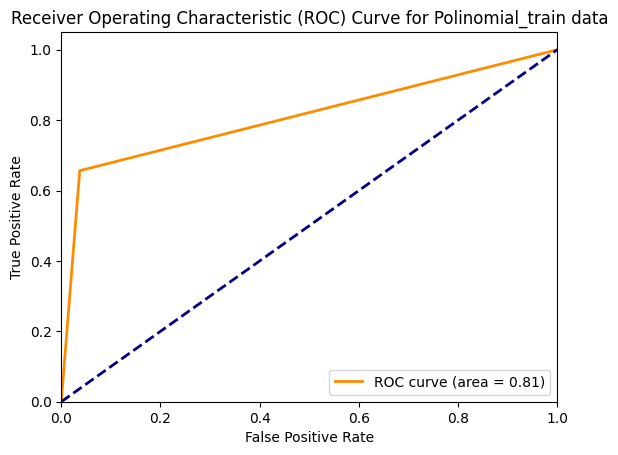

array([0., 0., 0., ..., 0., 0., 0.])

In [ ]:
predict_and_plot(model_pipeline_3,train_inputs, train_targets, name='Polinomial_train')

Area under ROC score on Polinomial_train dataset: 0.81%
F1 score on Polinomial_train dataset: 0.72%


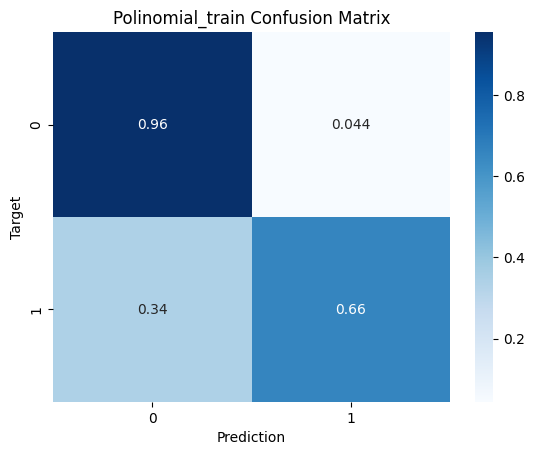

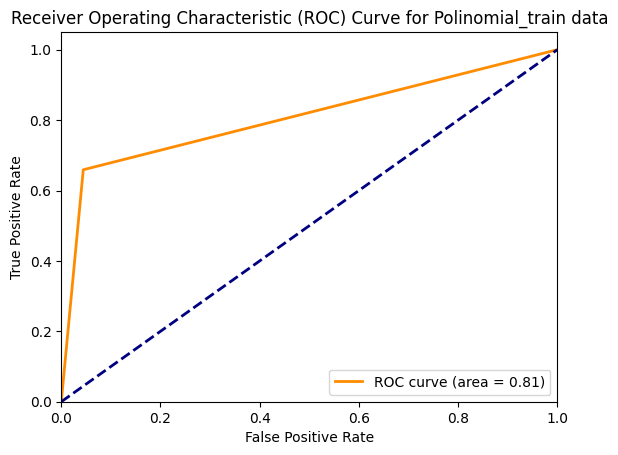

array([1., 0., 0., ..., 0., 0., 0.])

In [ ]:
predict_and_plot(model_pipeline = model_pipeline_3, inputs=val_inputs, targets=val_targets, name='Polinomial_train')

 Ця модель показує кращий результат: значення F1 та AUROC покращились у порівнянні з попередньою моделлю.

In [ ]:
test_raw_df = pd.read_csv('drive/MyDrive/ML/test.csv')

In [ ]:
test_raw_df.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,15000,15594796.0,Chu,584.0,Germany,Male,30.0,2.0,146053.66,1.0,1.0,1.0,157891.86,0.0
1,15001,15642821.0,Mazzi,551.0,France,Male,39.0,5.0,0.00,2.0,1.0,1.0,67431.28,0.0
2,15002,15716284.0,Onyekachi,706.0,France,Male,43.0,8.0,0.00,2.0,1.0,0.0,156768.45,0.0
3,15003,15785078.0,Martin,717.0,Spain,Male,45.0,3.0,0.00,1.0,1.0,1.0,166909.87,0.0
4,15004,15662955.0,Kenechukwu,592.0,Spain,Male,43.0,8.0,0.00,2.0,1.0,1.0,143681.97,0.0


In [ ]:
test_inputs= test_raw_df[input_cols]

In [ ]:
test_raw_df['Exited'] = model_pipeline_3.predict(test_inputs)

In [ ]:
submission_file = pd.read_csv('drive/MyDrive/ML/sample_submission.csv')

In [ ]:
submission_file['Exited'] = test_raw_df['Exited']

In [ ]:
submission_file.head()

,id,Exited
0,15000,0.0
1,15001,0.0
2,15002,0.0
3,15003,0.0
4,15004,0.0


In [ ]:
file_path = '/content/drive/MyDrive/ML/submission_log_reg.csv'
submission_file.to_csv(file_path, index=False)

**Завдання 4. Перенавчання і регуляризація**.

  Скачайте набір даних `regression_data.csv`. Звичайте набір даних з `regression_data.csv`, розбийте на train і test (в тест 20%) і натренуйте модель лінійної регресії з масштабуванням числових ознак і поліноміальними ознаками до степені **5 включно**.

  Виміряйте якість прогностичної моделі і зробіть висновок, чи модель хороша, чи вона добре генералізує?


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [ ]:
regression_data = pd.read_csv('drive/MyDrive/ML/regression_data.csv')

In [ ]:
regression_data.head()

,feature_1,feature_2,feature_3,feature_4,feature_5,target
0,-0.190339,-1.382800,-0.875618,0.538910,-1.037246,28.938854
1,-0.321386,-0.563725,0.412931,-0.147057,-0.825497,-7.664581
2,2.122156,-1.519370,1.032465,-1.260884,0.917862,-63.845482
3,-1.380101,-0.055548,-1.703382,0.074095,1.628616,4.076259
4,-0.072829,-1.514847,-0.846794,0.714000,0.473238,34.879013


In [ ]:
df_train, df_test = train_test_split(regression_data, test_size=0.2, random_state=42)

In [ ]:
input_columns = df_train.columns.difference(['target']).tolist()
target_column = 'target'

In [ ]:
X_train = df_train[input_columns]
y_train = df_train[target_column]
X_test = df_test[input_columns]
y_test = df_test[target_column]

In [ ]:
def pipeline(model, inputs, target, degree):
    numeric_transformer_4 = Pipeline(steps=[
      ('polinom', PolynomialFeatures(degree=degree)),
      ('scaler', MinMaxScaler())
  ])
    preprocessor_4 = ColumnTransformer(transformers=[
      ('num', numeric_transformer_4, input_columns)
  ])
    model_pipeline_4 = Pipeline(steps=[
      ('preprocessor', preprocessor_4),
      ('regression', model)
  ])
    model_pipeline_4.fit(inputs, target)
    return model_pipeline_4

In [ ]:
model = pipeline(model = LinearRegression(), inputs=X_train, target=y_train, degree=5)

In [ ]:
model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('polinom',
                                                                   PolynomialFeatures(degree=5)),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['feature_1', 'feature_2',
                                                   'feature_3', 'feature_4',
                                                   'feature_5'])])),
                ('regression', LinearRegression())])

In [ ]:
y_train_pred = model.predict(X_train)
y_test_pred =  model.predict(X_test)

In [ ]:
def model_estimation(y_actual,y_pred, df):
  rmse = mean_squared_error(y_actual,y_pred)
  mae = mean_absolute_error(y_actual,y_pred)
  r2 = r2_score(y_actual,y_pred)
  r2_min, r2_max = -1, 1
  r2_norm = (r2 - r2_min) / (r2_max - r2_min)
  print(f'RMSE for {df} data: {np.sqrt(rmse)}')
  print(f'MAE for {df} data: {mae}')
  print(f'R2 for {df} data: {r2}')
  print(f'R2_norm for {df} data: {r2_norm}')

In [ ]:
model_estimation(y_train_pred,y_train, 'training')

RMSE for training data: 2.0453470547033462e-13
MAE for training data: 1.5474353190411331e-13
R2 for training data: 1.0
R2_norm for training data: 1.0


In [ ]:
model_estimation(y_test_pred,y_test, 'testing')

RMSE for testing data: 12.363286870575406
MAE for testing data: 6.87856909115891
R2 for testing data: 0.9310006074436743
R2_norm for testing data: 0.9655003037218371


In [ ]:
regression_data.target.describe()

,target
count,129.000000
mean,-3.902984
std,45.466621
min,-111.753810
25%,-37.339533
50%,-0.641298
75%,25.464414
max,115.125907


In [ ]:
import statsmodels.api as sm

In [ ]:
X_train_const = sm.add_constant(X_train)
ols_model = sm.OLS(y_train, X_train_const).fit()
print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:                 target   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 3.320e+04
Date:                Fri, 31 Jan 2025   Prob (F-statistic):          3.88e-155
Time:                        14:54:30   Log-Likelihood:                -152.78
No. Observations:                 103   AIC:                             317.6
Df Residuals:                      97   BIC:                             333.4
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0288      0.111     -0.261      0.7

Показники моделі на тренувальних даних є досить високими, але здається, що модель перенавчилась, так як на валідаційних даних показники моделі стали погіршуватись. Також з додаткового аналізу p_value, видно, що найбільш стат значущою ознакою є feature_4.

**Завдання 5**. Натренуйте моделі Lasso(), Ridge(), ElasaticNet() на цих даних (з поліном ознаками до степені 20 включно), порівняйте якість з тою, яка була отримана з лінійною регресією. Яка модель найкраще генералізує і чому на ваш погляд (можливо треба буде для відповіді зробити додатковий аналіз ознак)?

In [ ]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet

In [ ]:
models = [
    Ridge(),
    Ridge(alpha=2),
    Lasso(),
    ElasticNet(),
    ElasticNet(alpha=0.5)
    ]

In [ ]:
for m in models:
  model=pipeline(m,X_train, y_train, degree=20)
  train_pred_values= model.predict(X_train)
  test_pred_values = model.predict(X_test)
  rmse_train = mean_squared_error(train_pred_values,y_train)
  rmse_test = mean_squared_error(test_pred_values,y_test)
  print(f'Model {str(m)}: RMSE_train: {np.sqrt(rmse_train):.2f}, RMSE_test: {np.sqrt(rmse_test):.2f}')

Model Ridge(): RMSE_train: 8.60, RMSE_test: 76.56
Model Ridge(alpha=2): RMSE_train: 12.41, RMSE_test: 94.08
Model Lasso(): RMSE_train: 5.10, RMSE_test: 5.67
Model ElasticNet(): RMSE_train: 34.18, RMSE_test: 116.03
Model ElasticNet(alpha=0.5): RMSE_train: 29.38, RMSE_test: 154.53


In [ ]:
model_ = pipeline(Lasso(),X_train, y_train, degree=20)

In [ ]:
y_train_pred_ = model_.predict(X_train)

In [ ]:
feature_names = model_.named_steps['preprocessor'].named_transformers_['num'].named_steps['polinom'].get_feature_names_out(input_columns)

In [ ]:
coefficients = model_.named_steps['regression'].coef_
coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})
coef_df = coef_df.sort_values(by='Coefficient', key=abs, ascending=False)

In [ ]:
coef_df

,Feature,Coefficient
4,feature_4,194.929248
0,1,0.000000
35424,feature_1^7 feature_3^3 feature_4^8 feature_5,-0.000000
35414,feature_1^7 feature_3^4 feature_4^8,-0.000000
35415,feature_1^7 feature_3^4 feature_4^7 feature_5,0.000000
...,...,...
17714,feature_1^3 feature_2 feature_3^6 feature_4 fe...,0.000000
17715,feature_1^3 feature_2 feature_3^6 feature_5^6,0.000000
17716,feature_1^3 feature_2 feature_3^5 feature_4^7,0.000000
17717,feature_1^3 feature_2 feature_3^5 feature_4^6 ...,-0.000000


Найкраще генералізує модель Lasso(). Згідно аналізу коефіцієнтів, видно, що найбільший вплив на нашу залежну зміну має ознака feature_4. Інші ознаки обнулились, що говорить про їх стат незначущість щодо нашої залежної змінної. Також модель Lasso() показала кращу стабільність у порівнянні з іншими моделями та моделлю LinearRegression(): значення RMSE на тестувальних та тренувальних данних майже не змінилось.